<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<a id='1'></a>
# Part 1. Getting Started- Load Python Packages

<a id='1.1'></a>
## 1.1. Install all the packages as described in the README file


<a id='1.3'></a>
## 1.2. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER, SP_500_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import itertools

<a id='1.4'></a>
## 1.3. Create Folders

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 2. Download Data

* We use the **YahooDownloader** class provided by FinRL to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [ ]:
TRAIN_START_DATE = '2010-01-04'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'
TRADE_START_DATE = "2022-01-03"
TRADE_END_DATE = "2022-10-03"

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = SP_500_TICKER).fetch_data()

# Part 3: Preprocess Data
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this experiment, we use two technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [7]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [8]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [75]:
processed

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2010-01-04,22.453505,22.625179,22.267525,20.122225,3815561,A,0,0.000000,0.000000,-66.666667,100.000000,0.000000
1,2010-01-04,4.840000,4.940000,4.660000,4.496877,9837300,AAL,0,0.000000,0.000000,-66.666667,100.000000,0.000000
2,2010-01-04,40.700001,41.040001,40.360001,36.130325,1701700,AAP,0,0.000000,0.000000,-66.666667,100.000000,0.000000
3,2010-01-04,7.622500,7.660714,7.585000,6.461976,493729600,AAPL,0,0.000000,0.000000,-66.666667,100.000000,0.000000
4,2010-01-04,26.000362,26.177889,25.870815,18.952164,10829095,ABT,0,0.000000,0.000000,-66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340950,2023-02-28,38.250000,38.919998,36.490002,37.306950,5997300,XRAY,1,0.017207,58.043088,88.761149,28.899093,592.177765
1340951,2023-02-28,16.350000,16.700001,16.309999,15.251863,1383200,XRX,1,0.009288,51.970410,-61.381017,2.623647,592.177765
1340952,2023-02-28,126.160004,127.599998,126.139999,124.761734,2624700,YUM,1,-0.129691,49.680510,-93.432299,13.078308,592.177765
1340953,2023-02-28,123.209999,124.190002,122.720001,122.685493,1341800,ZBH,1,-0.667180,49.909479,-75.515014,9.706858,592.177765


<a id='5'></a>
# Part 4: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* We have used the fine-tuned standard DRL algorithms provided by the FinRL library, such as DDPG, PPO, SAC, A2C and TD3.


In [11]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 405, State Space: 2431


In [12]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [14]:
model_kwargs = {
    'a2c': {
        'n_steps': 5,
        'ent_coef': 0.005,
        'learning_rate': 0.0007
        },

    'ppo': {
        "ent_coef":0.01,
        "n_steps": 2048,
        "learning_rate": 0.00025,
        "batch_size": 128
        },

    'ddpg': {
          "buffer_size": 10_000,
          "learning_rate": 0.0005,
          "batch_size": 64
        },

    'sac': {
        "batch_size": 64,
        "buffer_size": 100000,
        "learning_rate": 0.0001,
        "learning_starts": 100,
        "ent_coef": "auto_0.1",
        },
    
    'td3': {
        "batch_size": 100, 
        "buffer_size": 1000000, 
        "learning_rate": 0.0001
        }
}


In [13]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)


In [15]:
e_train_gym = StockTradingEnv(df = processed, **env_kwargs)
agent = DRLAgent(e_train_gym)

models = ['a2c', 'ppo', 'ddpg', 'sac', 'td3']

for modelname in models:
    model = agent.get_model(modelname, model_kwargs[modelname])
    tmp_path = RESULTS_DIR + modelname
    new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model.set_logger(new_logger)
    trained_model = agent.train_model(model=model,
                                 tb_log_name=modelname,
                                 total_timesteps=50000)

day: 3020, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 5914473.49
total_reward: 4914473.49
total_cost: 392746.02
total_trades: 722103
Sharpe: 0.810
======sac Validation from:  2022-01-03 to  2022-04-04
sac Sharpe Ratio:  -0.215761186826624
======ppo Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_189_2
-----------------------------------
| time/              |            |
|    fps             | 10         |
|    iterations      | 1          |
|    time_elapsed    | 191        |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.16233364 |
-----------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 10        |
|    iterations           | 2         |
|    time_elapsed         | 383       |
|    total_timesteps      | 4096      |
| train/       

<a id='6'></a>
# Part 5: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [48]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [112]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_a2c=pd.DataFrame()
df_ddpg=pd.DataFrame()
df_ppo=pd.DataFrame()
df_sac=pd.DataFrame()
df_td3=pd.DataFrame()
algodict = {'a2c': df_a2c, 'ddpg': df_ddpg, 'ppo': df_ppo, 'sac': df_sac, 'td3': df_td3}

for alg in models:
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format(alg,i))
        algodict[alg] = pd.concat([algodict[alg], temp], ignore_index=True)
    algodict[alg] = algodict[alg].join(df_trade_date[validation_window:].reset_index(drop=True))

<a id='6.1'></a>
## 5.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [118]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats = {}
for alg in models:
    print(alg)
    perf_stats[alg] = pd.DataFrame(backtest_stats(account_value=algodict[alg]))
    print('\n')

==============Get Backtest Results===========
a2c
Annual return         -0.063013
Cumulative returns    -0.063013
Annual volatility      0.323672
Sharpe ratio          -0.048356
Calmar ratio          -0.256697
Stability              0.012249
Max drawdown          -0.245476
Omega ratio            0.990335
Sortino ratio         -0.089594
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.879780
Daily value at risk   -0.040841
dtype: float64


ppo
Annual return         -0.087896
Cumulative returns    -0.087896
Annual volatility      0.318553
Sharpe ratio          -0.138826
Calmar ratio          -0.333537
Stability              0.112085
Max drawdown          -0.263526
Omega ratio            0.971325
Sortino ratio         -0.245368
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.893206
Daily value at risk   -0.040309
dtype: float64


ddpg
Annual return         -0.000298
Cumulative returns    -0.000298
Annual vola

In [120]:
#baseline stats
print("==============Get Baseline Stats===========")
df_sp500_ = get_baseline(
        ticker="^GSPC",
        start = algodict['a2c'].loc[0,'date'],
        end = algodict['a2c'].loc[len(algodict['a2c'])-1,'date'])

stats = backtest_stats(df_sp500_, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (546, 8)
Annual return          0.039839
Cumulative returns     0.088329
Annual volatility      0.183010
Sharpe ratio           0.305578
Calmar ratio           0.157805
Stability              0.302814
Max drawdown          -0.252460
Omega ratio            1.052968
Sortino ratio          0.414114
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.950276
Daily value at risk   -0.022835
dtype: float64


In [126]:
df_sp500 = pd.DataFrame()
df_sp500['date'] = df_account_value['date']
df_sp500['sp500'] = df_sp500_['close'] / df_sp500_['close'][0] * env_kwargs["initial_amount"]
print("df_sp500: ", df_sp500)
df_sp500.to_csv("df_sp500.csv")
df_sp500 = df_sp500.set_index(df_sp500.columns[0])
print("df_sp500: ", df_sp500)
df_sp500.to_csv("df_sp500+.csv")


df_sp500:             date         sp500
0    2022-01-03  1.000000e+06
1    2022-01-04  1.003612e+06
2    2022-01-05  1.010065e+06
3    2022-01-06  1.016557e+06
4    2022-01-07  1.017201e+06
..          ...           ...
247  2022-12-27  1.335958e+06
248  2022-12-28  1.335709e+06
249  2022-12-29  1.341327e+06
250  2022-12-30  1.334076e+06
251  2023-01-03  1.331617e+06

[252 rows x 2 columns]
df_sp500:                     sp500
date                    
2022-01-03  1.000000e+06
2022-01-04  1.003612e+06
2022-01-05  1.010065e+06
2022-01-06  1.016557e+06
2022-01-07  1.017201e+06
...                  ...
2022-12-27  1.335958e+06
2022-12-28  1.335709e+06
2022-12-29  1.341327e+06
2022-12-30  1.334076e+06
2023-01-03  1.331617e+06

[252 rows x 1 columns]


In [ ]:
for alg in models:
    algodict[alg].to_csv(alg + '.csv')

<a id='6.2'></a>
## 5.2 BackTestPlot

In [71]:
result = pd.DataFrame()
for alg in models:
    result = pd.merge(result, algodict[alg][["account_value", "date"]].set_index('date').rename(columns={'account_value': alg}), on='date', how='inner')

result.to_csv("result.csv")

ind:  Empty DataFrame
Columns: []
Index: []


Text(0, 0.5, 'Cumulative Return')

<Figure size 1500x500 with 0 Axes>

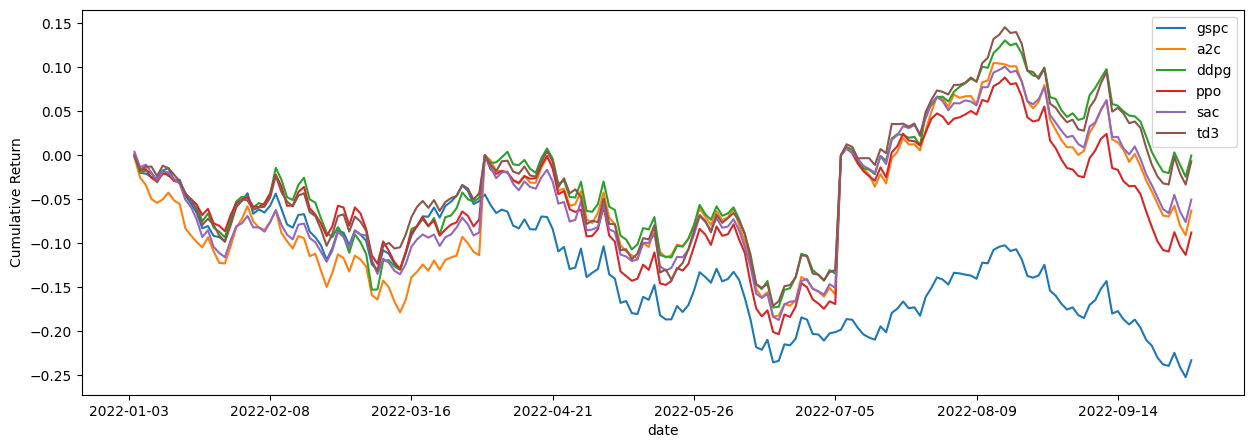

In [101]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
(res[:].diff().cumsum()/1e6).plot()
plt.ylabel('Cumulative Return')